# Calculate alpha value for reanalysis and model data

In [1]:
import os
from importlib import reload
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as ctp
import seaborn as sns
from sklearn import mixture, decomposition
import scipy.optimize as opt

from latgmm.utils import utenso, preproc, eof, utdata, utstats, metric
import latgmm.geoplot as gpl

plt.style.use("../../paper.mplstyle")

## Load LENS data

In [2]:
path = "../../data/cmip6/historical/CESM2"
normalization = None

ensemble_list = []
for folder_name in os.listdir(path)[:20]:
    full_path = os.path.join(path, folder_name)
    if os.path.isdir(full_path):
        print(f'Load data in folder: {folder_name}')
        forcing, inityear, member = folder_name.split("_")
        fname = os.path.join(full_path, f'b.e21.BHIST{forcing}.f09_g17.LE2-{inityear}.{member}.ssta_lat-31_33_lon130_290_gr1.0.nc')
        buff = xr.open_dataset(fname)
        buff = buff.assign_coords(member=('time', [folder_name]*len(buff.time)))
        ensemble_list.append(buff)
print("Merge members!")
ds_lens = xr.concat(ensemble_list, dim='time')
ds_lens['lon'] = preproc.get_antimeridian_coord(preproc.lon_to_180(ds_lens['lon']))

Load data in folder: smbb_1301_014
Load data in folder: cmip6_1281_005
Load data in folder: smbb_1231_017
Load data in folder: cmip6_1251_004
Load data in folder: cmip6_1181_010
Load data in folder: cmip6_1251_006
Load data in folder: cmip6_1251_007
Load data in folder: cmip6_1301_004
Load data in folder: smbb_1281_017
Load data in folder: smbb_1251_016
Load data in folder: smbb_1301_020
Load data in folder: smbb_1281_014
Load data in folder: cmip6_1281_004
Load data in folder: smbb_1071_004
Load data in folder: cmip6_1101_006
Load data in folder: smbb_1231_015
Load data in folder: cmip6_1231_003
Load data in folder: cmip6_1231_009
Load data in folder: smbb_1301_017
Load data in folder: smbb_1231_014
Merge members!


In [3]:
datafile = "../../data/cmip6/piControl/CESM2/ssta_lat-31_32_lon130_-70_gr1.0_norm-zscore.nc"
ds_piControl = xr.open_dataset(datafile)
ds_piControl = ds_piControl.assign_coords(member=('time', [1]*len(ds_piControl.time)))

In [4]:
# Load reanalysis data
datafile = "../../data/reanalysis/monthly/ssta_merged_dataset_1.nc"
ds_reanalysis = xr.open_dataset(datafile)
# Get common land sea mask from model
mask1 = ds_lens['ssta'].isel(time=0).isnull()
mask2 = ds_reanalysis['ssta'].isel(time=0).isnull()
merged_mask = np.logical_or(mask1, mask2)

ds_lens = ds_lens.where(~merged_mask, other=np.nan)
ds_reanalysis = ds_reanalysis.where(~merged_mask, other=np.nan)
ds_piControl = ds_piControl.where(~merged_mask, other=np.nan)

In [5]:
keys = ['Reanalysis', 'LENS']
data = [ds_reanalysis, ds_lens]
normalization = 'zscore'
n_components = 2

# EOF analysis for each dataset
pca_transform = []
for key, ds in zip(keys, data):
    ds4eof = ds.sel(lat=slice(-10,10))

    # Normalization
    if normalization is not None:
        attributes = {}
        ds_norm = []
        for var in list(ds4eof.data_vars):
            scaler = preproc.Normalizer(method=normalization)
            buff = scaler.fit_transform(ds4eof[var])
            buff.attrs = {'normalizer': scaler}
            ds_norm.append(buff)

        ds4eof = xr.merge(ds_norm) 

    sppca = eof.SpatioTemporalPCA(ds4eof, n_components=n_components)
    print(f"Explained variance: {np.sum(sppca.explained_variance())}")
    if key == 'CESM2':
        sppca.pca.components_[0,:] = -sppca.pca.components_[0,:]
    pca_transform.append(sppca)

Explained variance: 0.7783088683890378
Explained variance: 0.8104214347222167


In [6]:
def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c

alpha=0.3900747557918445
alpha=0.25919937174249796


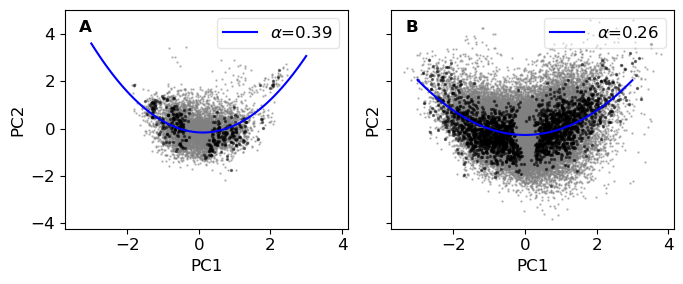

In [8]:
n_ds = len(data)
fig, axs = plt.subplots(1, n_ds, figsize=(7, 3), sharex=True, sharey=True)

for i, ds in enumerate(data):
    ds = ds.sel(lat=slice(-10,10))
    # Select ENSO events
    month_range = [12, 2]
    ds_enso, ds_events = utenso.select_enso_events(ds, month_range=month_range, threshold=0.5)
    # DJF
    #ds = ds.sel(time=ds['time.season']=='DJF')

    # Transform data to EOF space
    pca = pca_transform[i]
    z = pca.transform(ds)
    axs[i].scatter(z[:,0], z[:,1], s=.5, color='gray', alpha=0.5)
    z_enso = pca.transform(ds_events)
    axs[i].scatter(z_enso[:,0], z_enso[:,1], s=2, color='k', alpha=0.5)

    # Curve fit
    popt, _ = opt.curve_fit(quadratic_func, z[:,0], z[:,1])
    # Extract the coefficients
    a, b, c = popt
    print(f"alpha={a}")
    # Generate fitted values
    pc1_fit = np.linspace(-3, 3, 100)
    pc2_fit = quadratic_func(pc1_fit, a, b, c)

    axs[i].plot(pc1_fit, pc2_fit, color='b', label=rf"$\alpha$={a:.2f}")
    
    axs[i].legend(loc=1)
    axs[i].set_xlabel(f"PC1")
    axs[i].set_ylabel(f"PC2")

gpl.enumerate_subplots(axs, pos_x=0.05, pos_y=0.9)

plt.savefig("../../output/plots/si_pcs_alpha.png", dpi=1000, bbox_inches='tight')
